# Lesson 5.分类模型决策边界与模型评估指标（中）

接下来，我们重点讨论关于分类模型评估指标相关内容。

In [3]:
# 科学计算模块
import numpy as np
import pandas as pd

# 画图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# 自定义模块
from ML_basic_function import *

## 三、混淆矩阵与F1-Score

分类模型作为使用场景最为广泛的机器学习模型，相关模型评估指标也伴随着使用场景的拓展而不断丰富。除了此前所介绍的准确率以外，常用的二分类模型的模型评估指标还有召回率(Recal)、F1指标(F1-Score)、受试者特征曲线(ROC-AUC)、KS曲线等等。不同评估指标有对应的不同的计算方法，当然也有不同的使用场景。

接下来，我们就依据不同评估指标彼此之间的计算关系来对二分类问题的模型评估指标进行统一介绍，并给出对应指标使用场景的介绍。

### 1.准确率局限

首先，是准确率作为横型评估指标时的局限。整体来看，准确率作为最为通用、同时也是较好理解的评估指标，在机器学习领域其实仍然存在一定局限。当然，归根结底，这些局限其实是由准确率本身的计算过程所决定的。首先也是最重要的一点，就是准确率在计算过程中，所有样本其实是均匀投票"的，也就是说对悔个样本的判别结果，对于最终准确率的影响其实是相同的。例如假设总共有100条数据进行分类，其中任意一条样本被误判都会且仅会影响1%的准确率。如此一来就会造成两方面影响，其一，对于某些样本极端不平衡的分类数据集来说准确率很难很好的衡量模型表现，例如，假设总共有100样本，其中0类有99条，1类有1条，则此时就算模型判别此100条样本全都为0类，准确率也将达到99%，但很多时候可能我们希望的是模型能够将这些1识别出来，例如癌症病患数据中癌症患者、金融风控中欺诈用户等。当然，从更加本质的角度来看，那就是在很多业务场景中，将0错判为1、和将1错判为0,其实实际付出的代价是不一样的，很多时候我们并不是单纯的追求将所有的0样本都正确的识别为0且将1样本都正确的判别为1，而是根据误判的代价，选择更加激进或者更加保守的策略来进行识别。例如如果将1样本误判为0的代价非常大，而将0样本误判为1的代价并不大，则会采用”宁可错杀一千、不可放过一个的激进策略来识别1。

关于准确率的第二方面局限，实际上是一个相对隐藏更深的问题，那就对于哪怕是均衡的分类样本数据集，准确率有时也无法很好的衡量分类模型的分类性能、尤其是模型本身的泛化能力，这也是为什么我们不以火准确率而以交叉嫡作为损失函数的另一个原因。例如，假设对下述5条样本的二分类数据集，构建A、B两个逻辑回归模型进行判别，模型判结果如下所示：

![Alt text](image-75.png)

如果是从准确率指标来看，两个模型在阈值为0.5的情况下，判别准确率都是80%（仅判错第二条样本），二者并无高下之分。但如果我们更加仔细的观察横型对各样本输出的概率预测结果，其实我们会发现模型A其实会更加优秀”：首先，对于判断正确的1类数据，模型八输出的概率预测分别为0.8、0.9和0.9，表示模型非常肯定这些样本应该属于1类，而模型B的概率预测结果为0.6、0.7、0.6,表示模型并不是特别肯定这样样本属于1类，类似的情况也出现在两个模型正确识别0类的判别过程中。此外，对于误判的样本，虽然两个模型都将原本属于0类的2号样本误判为1，但模型B给出的概率结果是0.9，代表其非常肯定该样本应该属于1类，而横型A输出的概率结果为0.6，表示其并不是非常肯定该样本属于1类。在实际建模过程中，类似A模型的模型，即对判断正确的样本有较高的肯定、对判断错误的样本不太肯定，这类模型其实是更加准确的捕捉到了数据规律，在后续对于新数据集预测时，也将拥有更强的泛化能力。但遗憾的是，准确率评估指标并无法很好的将A类模型和B类模型的模型判别能力进行准确区分。

此时我们可以通过交叉熵来比较两个模型的好坏优劣。我们知道，交叉熵计算结果越小、模型本身判别能力越强，我们尝试借助交叉嫡计算公式来计算两个模型输出结果的交叉熵：

$$
BCE_{A}=\frac{-\log _2(0.8)-\log _2(0.4)-\log _2(0.8)-\log _2(0.9)-\log _2(0.9)}{5}
$$

In [4]:
-(np.log(0.8) + np.log(0.4) + np.log(0.8) + np.log(0.9) + np.log(0.9))/5

0.31465977316364546

$$
BCE_{B}=\frac{-\log _2(0.6)-\log _2(0.1)-\log _2(-0.6)-\log _2(0.7)-\log _2(0.6)}{5}
$$

In [5]:
-(np.log(0.6) + np.log(0.1) + np.log(0.6) + np.log(0.7) + np.log(0.6)) / 5

0.83834738164615

> 此处也可以直接调用此前定义的BCE函数进行计算

能够看出，模型A输出结果的交叉熵是要小于模型B的，因此模型A其实拥有对慨定样本更强的判别能力。此时我们发现，无论是从通俗的角度看模型对样本类别判别的肯定程度，还是从交叉熵计算结果来看，模型A、B实际上是存在判别能力的差异的，但这种差异无法被准确率很好的衡量。

既然能够通过交叉熵观察模型判别能力，那为何我们不选取交叉熵作为模型评估指标？

其实交叉熵一般不作为模型评估指标的主要原因有两个方面，其一是交叉嫡的取值并不在一个固定的区间范围内，
交叉熵=相对嫡+信息熵，由于相对熵大于等于0的特性，所以交叉熵实际上是在信息熵+∞内取值，而不在一个固定区间内取值就导致交叉熵数值很难进行不同模型间横向对比；其二则是尽管在建模的时候我们是通过梯度下降求解交叉嫡损失函数的最小值，此时我们希望交叉嫡的值越小越好，但其实有的时候，一味追求交叉熵更小的值也有可能导致模型过拟合，因此实际上交叉嫡的值也不是越小越好，此时甚至会需要结合准确率来综合调参，寻找一个准确率较高、但交叉熵不是特别小的模型，来削弱过拟合倾向。因此，在绝大多数时候，交叉熵的主要功能还是作为指导模型进行参数求解的损失函数。

而为了修正准确率的均匀投票"在某些场景下的缺陷，我们将引入混淆矩阵、召回率、精确度、F1-Scoe等指标来完善模型评估指标体系，而为了更好的评估模型整体分类效力，我们将引入ROC-AUC等指标，此外我们还将介绍用于模型结果代价衡量和辅助判别最佳阈值的K-S曲线。

### 2.混淆矩阵（Confusion matrix）

混淆矩阵作为分类摸型结果的更加细致精确的可视化展示，有时也被称为误差矩阵或者可能性表格，通常混淆矩阵会应用于二分类问题中，对此首先有如下关键定义：

* Actual condition :样本真实标签
* Predicated condition: 模型预测标签

例如，有如下数据集，第一列为真实标签，即Actual condition，第二列为模型预测结果，即Predicated conditon，数据集如下：

![Alt text](image-76.png)

而在不同标签类别方面，则可进一步细分为：

* Actual condition positive(P):样本中阳性样本总数，一般也就是真实标签为1的样本样本总数；
* Actual condition negative(N):样本中阴性样本总数，一般也就是真实标签为0的样本总数；
* Predicted condition positive(PP): 预测中样本总数，一般也就是预测标签为1的样本总数；
* Predicted condition negative(PN): 预测中阴性样本总数，一般也就是预测标签为0的样本总数；
  

对于上述数据集而言，P=8，N=4，PP=7，PN=5。并且，样本总数为12

此外，在进行二分类模型预测过程中，样本类别被模型正确识别的情况其实有两种，一种是阳性样本被正确识别，另一种是阴性样本被正确识别，据此我们可以有如下定义：

* True positive(TP): 样本属于阳性（类别1），并且被正确识别为阳性（类别1）的样本总数；TP发生时也被称为正确命中（hit）；
* True negative(TN): 样本属于阴性（类别0），并且被正确识别为阴性（类别0）的样本总数；TN发生时也被称为正确拒绝（correct rejection）;

对于上述数据集而言，TP=6,TN=3。

当然，对于误分类的样本，其实也有两种情况，其一是阳性样本被误识别为阴性，其二是阴性样本被误识别为阳性，据此我们也有如下定义：

* False positive(FP):样本属于阴性(类别0),但被错误判别为阳性(类别1)的样本总数：FP发生时也被称为发生类了错误(Type I error),或者假警报(False alarm)、低估(underestimation)等;

*  False negative(FN):样本属于阳性(类别1)，但被错误判别为阴性(类别0)的样本总数；FN发生时也被称为发生了II类错误(TypeⅡI error),或者称为错过目标(miss)、高估(overestimation)等；

对于上述数据集而言，FP=1,FN=2。

> 不难发现，混淆矩阵其实具有非常强的统计表的背景，并且和此前介绍的一样、也是更倾向于重点识别1类（阳性）样本。

![Alt text](image-77.png)

对于上述数据集，混淆矩阵计算结果为：

![Alt text](image-78.png)

### 3.混淆矩阵中的模型评估指标

#### 3.1 围绕识别类别1所构建的评估指标

当然，对于混淆矩阵来说，其实仍然属于第一级观察指标，通过混淆矩阵，通常我们并不会直接使用混淆矩阵中的一级指标，而是去使用基于这些一级指标的二级指标。例如从上述混淆矩阵所提供的结果不难看出，准确率其实就是$A C C=\frac{T P+T N}{T P+T N+F P+F N}$ 。当然，此外其实还有其它很多常用的二级指标，通过这些二级指标的构建，可以补充准确率在偏态样本中重点识别某类样本时表现的不足。首先，如果是更加关注类别1的识别情况，则有两个常用指标：

* 召回率（Recall）

召回率侧重于关注全部的1类样本中被准确识别出来的比例，其计算公式为：

$$
\text { Recall }=\frac{T P}{T P+F N}
$$

对于上例中，全部12条样本中有8条1类样本，而其中有6条被准确识别，因此上述召回率为6/8=75%。

根据召回率的计算公式我们可以试想，如果以召回率作为模型评估指标，则会使得模型非常重视是否把1全部识别了出来，甚至是牺牲掉一些0类样本判别的准确率来提升召回率，即哪怕是错判一些0样本为1类样本，也要将1类样本识别出来，这是一种"宁可错杀干不可放过一个"的判别思路。因此，召回率其实是一种较为激进的识别1类样本的评估指标，在0类样本被误判代价较低、而1类样本被误判成本较高时可以考虑使用。“宁可错杀一千不可放过一个”。

当然，对于极度不均衡样本，这种激进的判别指标也能够很好的判断模型有没有把1类样本成功的识别出来。例如总共100条数据，其中有99条样本标签为0、剩下一条样本标签为1，假设模型总共有A、B、C三个模型，A模型判别所有样本都为0类，B模型判别50条样本为1类50条样本为0类，并且成功识别唯一的一个1类样本，C模型判别20条样本为1类、80条样本为0类，同样成功识别了唯一的一个1类样本，则各模型的准确率和召回率如下：

![Alt text](image-79.png)

不难发现，在偏态数据中，相比准确率，召回率对于1类样本能香被正确识别的敏感度要远高于准确率但对于是否牺牲了0类别的准确率却无法直接体现。

此外，召回率往往还被称为sensitivity（敏感度）、hit rate（命中率）、true positive rate(TPR)以及查全率等。

* 精确度（Precision）

和召回率不同，精确度并不主张宁可错杀干不可放过一个”，而是使加关注每一次出手(对1类样本的识别)能否成功（准确识别出1)的概率，精确度计算公式为：

$$
\text { Precision }=\frac{T P}{T P+F P}
$$

对于上例中，全部12条样本，模型总共判别7条样本为1类样本，但其中有6条判别准确，精确度为67=86%。

当然，也正是由于这种力求每次出手都尽可能成功的策略，使得当我们在以精确度作为模型判别指标时，模型整体对1的判别会趋于保守，只对那些大概率确定为1的样本进行1类的判别，从而会一定程度牺牲1类样本的准确率，在每次判别成本较高、而识别1样本获益有限的情况可以考虑使用精确度。

同样，对于召回率中所举的例子来看，此时A、B、C三个模型的精确度为：

![Alt text](image-80.png)

能够发现，对于偏态样本，相比准确率，精确度能够一定程度反应是否成功识别出1类样本（尽管敏感度不如召回率），并且能够较好的反应对0类样本准确率的栖牲程度。

此外，精确度有时也被称为positive predictive value(PPV)和查准率等。

关于召回率和准确率，也可以通过如下形式进行更加形象的可视化展示

![Alt text](image-81.png)

* F1-Score

不难发现，召回率和精确度其实是一对相对的概念，在围绕1类样本的识别过程中，召回率力求尽可能更多的将1识别出来，而精确度则力求每次对1样本的判别都能获得一个正确的结果。但是，再大多数情况下，其实我们是希望获得一个更加"均衡”的模型判别指标，即我们既不希望模型太过于激进、也不希望模型太过于保守，并且对于偏态样本，既可以较好的衡量1类样本是否被识别，同时也能够兼顾考虑到0类样本的准确率牺性程度，此时，我们可以考忠使用二者的调和平均数(harmonic mean)作为模型评估指标，即F1-Score。

所谓A和B的调和平均数，指的是$\frac{2}{\frac{1}{A}+\frac{1}{B}}=\frac{2 A B}{A+B}$的计算结果，则F1-Score计算公式如下：

$$
F 1-\text { Score }=\frac{2}{\frac{1}{\text { Recall }}+\frac{1}{\text { Precision }}}=\frac{2 \cdot \text { Recall } \cdot \text { Precision }}{\text { Recall }+ \text { Precision }}
$$

当然，通常我们也会用TPR表示Recall，PPV表示Precision，此时F1-Score可表示如下：

$$
F 1-S c o r e=\frac{2 \cdot T P R \cdot P P V}{T P R+P P V}
$$

如果更近一步用混淆矩阵的一级指标来进行表示，则：

$$
F 1-S \text { core }=\frac{2 \cdot T P}{2 \cdot T P+F P+F N}
$$

根据F1-Scoref的计算公式不难发现，F1-Score是一个介于[0,1]之间的计算结果，当FP+FN=0时候（即没有误判样本时），F1-Scorei计算结果为1；而当没有正确识别出一个1时，即TP=0时，F1-Score=0。

对于偏态样本中的建模结果来说，此时A、B、C三个模型的F1-Score为：

![Alt text](image-82.png)

对于下述混淆矩阵来说，F1-Score计算结果为$\frac{12}{12+2+1}=0.8$

![Alt text](image-83.png)

* F1-Score基本性质

当然，从上述结果来看，F1-Score指标能够一定程度上综合Recall和Precision的结果，综合判断模型整体分类性能。当然，除了F1-Score以外我们还可以取Recall和Precision的均值balanced accuracy,简称BA来作为模型评估指标：

不过，相比平均数，调和平均数其实会更大程度上受到短板数据的影响。从上述结果不难发现，从模型B到模型C,F1-Scor的数值增长幅度和Precision涨幅类似，这其实就是由F1-Scoref的调和平均数的性质决定的。关于这点，我们可以通过下面一组代码实验来进行相关测试：

In [6]:
def harmonic_mean(a, b):
    return 2*a*b/(a+b)

In [7]:
A = np.linspace(0, 1, 100)
B = np.ones(shape= A.shape)

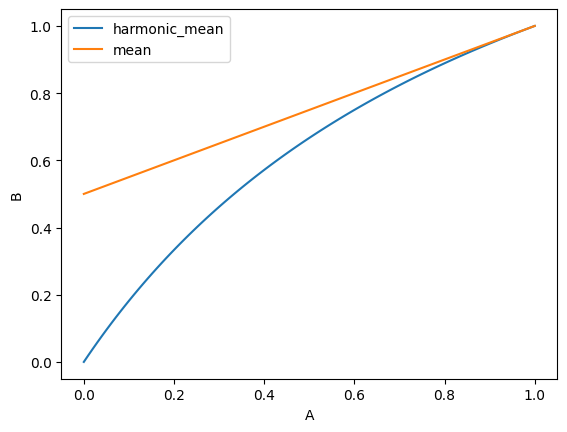

In [8]:
plt.plot(A, harmonic_mean(A, B), label='harmonic_mean')
plt.plot(A, (A + B)/2, label = 'mean')
plt.xlabel('A')
plt.ylabel('B')
plt.legend()

能够看出，调和平均数和均值相比，其实会更大程度受到短板数据影响，从这个角度来看，F1-Sc0其实会更加严格，即只要参与计算的Recall和Precision:其中一个指标较小，F1-Score指标就会整体偏小，而当F1-Score结果较大时，则说明模型整体分类性能较强，并且哪怕是极端不平衡数据，只要F1-Sco计算结果较大，就说明横型对少数类别样本也具有很好的分类性能，从这个角度来说，F1-Score是个比ACC更全面的评估指标，并且，为了能够更严格的要求模型训练过程以期达到一个更好的建模效果，我们往往更倾向于采用F1-Score作为模型评估指标，而不是BA。

> 除了F1-Scor以外，还有一种更为一般的、可以自主调整召回率和精确度在参与调和平均数计算过程中的权重的评
估指标$F_\beta$,其计算公式如下：

$$
F_\beta=\left(1+\beta^2\right) \frac{\text { precision } \cdot \text { recall }}{\left(\beta^2 \cdot \text { precision }\right)+\text { recall }}
$$

值得注意的是，F1-Score并不是类别对称的，也就是说，如果我们将0类和1类数据标签互换，最终算得的F1-Socre结果会有所不同。因此其实F1-Sco虽然是一个更加均衡的评估指标，但其实也只是均衡了在识别1类样本时"激进"或者”保守"的倾向性，但本质上还是一个围绕模型对1类样本识别能力所构建的评估指标。

#### 3.2 围绕识别类别0所构建的评估指标

* 特意度（Specificity）

首先是用来衡量0类被正确识别比例的特异度，该指标类似召回率，都是较为激进的评估指标，只考虑关注的类（0类或者1类）被识别出*的比例，而不考虑在识别过程中是否牺牲了另外一类的准确率。该指标计算公式如下：

$$
\text { Specificity }=\frac{T N}{T N+F P}
$$

同样，对于上述例子来看，特异度计算结果为3/4=0.75。

![Alt text](image-84.png)

此外，特异度往往也被称为true negative rate(TNR)。

* 阴性预测值（Negative predictive value）

同样，类似Precision,对于0类样本的衡量，也有一个相对保守评估指标，用于衡量对0类样本进行判别的所有判别结果中正确识别的0类样本所占得比例，也就是阴性预测值指标，往往也被称为NPV(negative predictive value),其计算公式如下：

$$
N P V=\frac{T N}{T N+F N}
$$

而对于上述例子来说，NPV计算结果为3/5=0.6

不过，需要注意的是，尽管有一套和识别1类镜像的识别0类的指标，但是，通常来说，我们还是会倾向于将重点识别的类别划为1类，然后采用围绕1类构建的指标来进行模型评估，而不是将其任意划为1类或者0类，然后选取对应类别评估指标来进行模型评估。

此外，对于F1-Score指标来说，尽管其能够间接兼顾0类别的判别情况，但归根结底，F1-Score仍然还是围绕类别1的识别健立起来的评估指标，因此如果重点识别类别是0类，那么还是建议先将其改为1类，然后再利用F1-Scoe进行建模。

> 其实我们仿造F1-Scoret构造一个由TNR和NPV的调和平均数计算结果指标，通过验证该指标和F1-Scorei计算结果的不同，来证明F1-Score其实并非0-1类别对称指标。

> F1-Score指标的非对称性主要是受到不同类别样本数量影响。

* 伪阳率（false positive fate）

除了上述指标外，我们还需要补充一个对后续会经常用到的一个评估指标：，伪阳率(false positive rate),其计算公式为：

$$
F P R=1-\text { specificity }=\frac{F P}{F P+T N}
$$

即表示在所有预测为0类的样本中，错误样本所占比例。

> 此外，Matthews correlation coefficient（马修斯相关系数）、Fowlkes--Mallows index（聚类评价标准）系数等常用评估指标。

### 4.混淆矩阵评估指标使用策略

在介绍了这么多基于混淆矩阵的评估指标之后，接下来我们简单总结这些评估指标的一般使用策路。首先，在类别划分上，仍然需要强调的是，我们需要根据实际业务情况，将重点识别的样本类划为类别1，其他样本划为类别0。当然，如果0、1两类在业务判断上并没有任何重要性方面的差异，那么我们可以将样本更少的那一类划为1类。

其次，在评估指标选取上，同样需要根据业务情况判断，如果只需要考虑1类别的识别率，则可考虑使用Recall作为模型评估指标，若只需考虑对1样本判别结果中的准确率，则可考虑使用Precisio作为评估指标。但一般来说这两种情况其实都不多，更普遍的情况是，需要重点识别1类但也要兼顾0类的准确率，此时我们可以使用F1-Score指标。目前来看，F1-Scoe其实也，是分类模型中最为通用和常见的分类指标。

当然，在某些情况下，例刚如使用Sckt-Lea利用网格搜索进行模型调参时，对于某些本身分类性能比较强（本身对两类都能进行较好识别）的模型，我们可以适时采用召回率作为网格搜索评价指数，来提升1类识别准确率。

### 5. 多分类混淆矩阵

般来说混清矩阵常用于二分类问题，对于多分类问题，我们同样可以构建如下形式的混淆矩阵：

![Alt text](image-85.png)

此时，如果要进行Reca、Precision的计算，则需要先采用此前个绍的OVR策略进行”划分”、然后采用均值策略进行集成"”，依次将A、B、C视为1类，其余类别视为0类来进行计算，例如，A、B、C三类的Recall为：

$$
\begin{gathered}
\text { Recall }_A=\frac{6}{6+2+2}=0.6 \\
\operatorname{Recall}_B=\frac{3}{3+1+3}=\frac{3}{7}=0.42 \\
\text { Recall }_C=\frac{2}{2+2+6}=0.2
\end{gathered}
$$

然后，进行均值计算，即可算得此时模型整体Recall:

$$
\text { Recall }=\frac{0.6+0.42+0.2}{3}=0.4
$$

类似，可以算得Precision $_A=\frac{6}{13}=0.46$, Precision $_B=\frac{3}{7}=0.42$, Precision $_C=\frac{2}{7}=0.28$, 随后利用三者均值求出模型整体Precision $=0.38$ 。

当然，我们也可以计算模型整体F1-Scoe,此时仍然需要分别计算A、B和C三个模型的F1-Score,然后利用均值进行集成即可。